# Auto correlation (ACF, PACF), Auto Regressive Models

### Revisão
- Detecção de Tendência e Sazonalidade
    - Exploração Visual
    - Decomposição de Séries Temporais (HP-Filter e STL)
- Estacionariedade (Conceito e testes)
- Alisamento Exponencial (Simples, Duplo e Triplo)
- Introdução ao operador lag e auto correlação
### Hoje
- Revisão 
- Transformações para atingir estacionariedade
- Operador Lag
- ACF e PACF
- Modelos AR
- Modelos ARI

### Preparação


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.datasets import co2, get_rdataset
plt.rcParams["figure.figsize"] = [12, 5]
file = Path('/Users/danielferreira/Documents/git/classes/ASN/Séries Temporais/dados/closing_price.csv')
closing_price = pd.read_csv(file, index_col='Date',parse_dates=True).resample('MS').mean()
co2_df = co2.load_pandas().data
co2_s = co2_df.ffill().resample('MS').mean()
air_passengers = get_rdataset("AirPassengers")
airp_s = air_passengers.data
airp_s.index = pd.date_range('1949', '1960-12', freq='MS')
airp_s.drop(columns=['time'], inplace=True)
df = pd.read_csv('/Users/danielferreira/Documents/git/classes/ASN/Séries Temporais/dados/netflix_titles.csv')
df['date_added']=pd.to_datetime(df['date_added'], format='%B %d, %Y', errors = 'coerce')
df.index = df['date_added']
lancamentos = df.set_index('date_added').resample('MS').size()
netflix = lancamentos[lancamentos.index.year>2015]

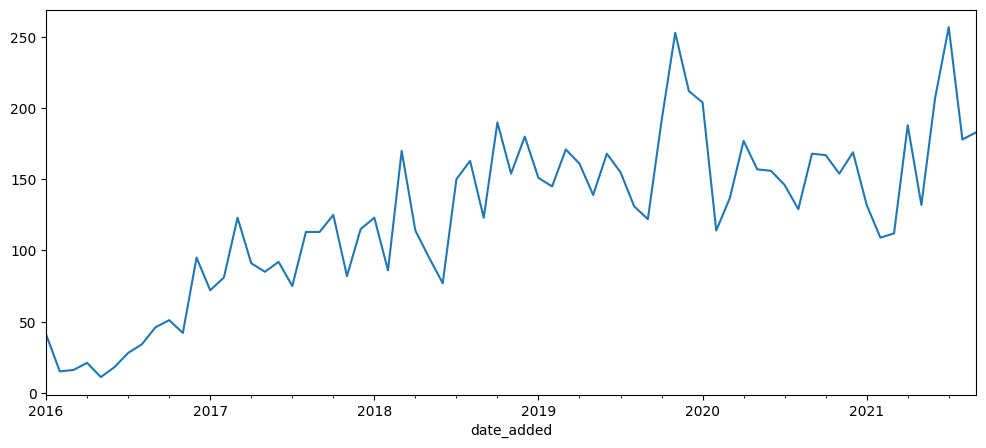

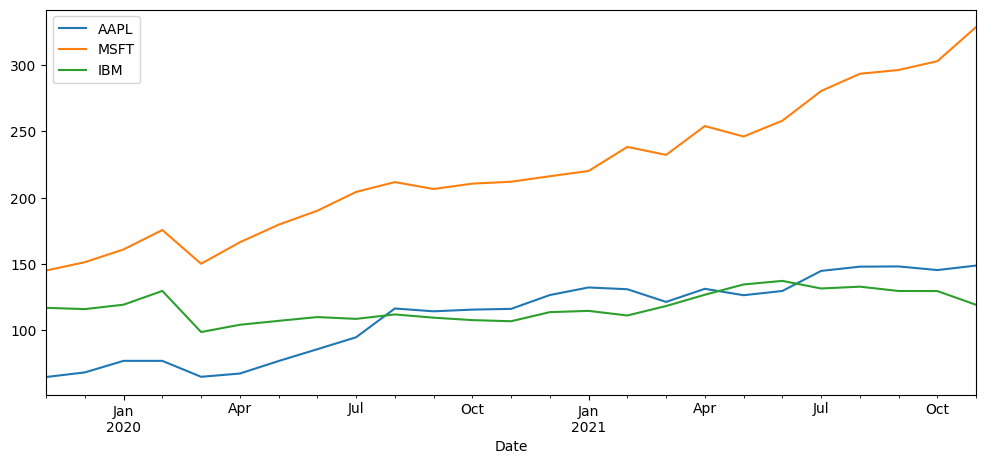

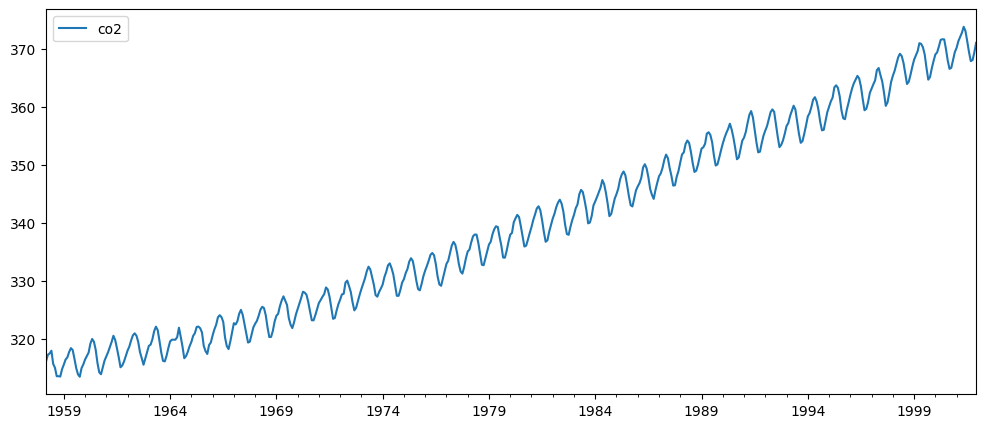

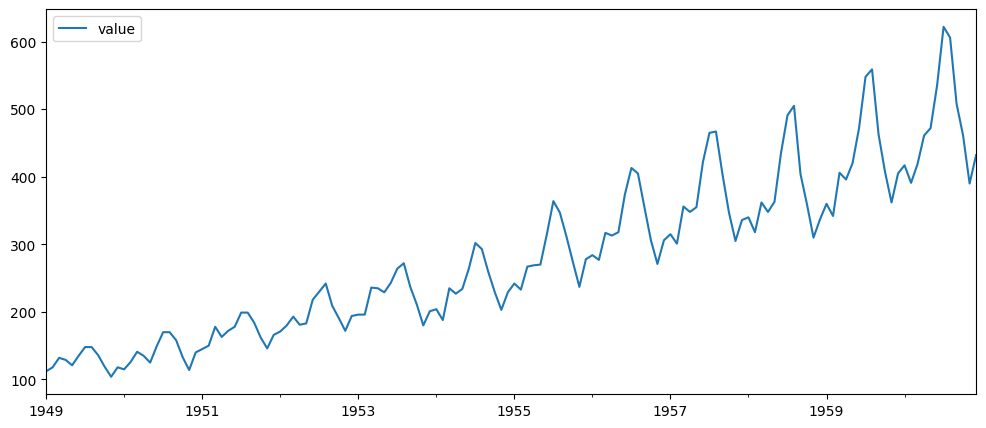

In [2]:
for s in [netflix,closing_price, co2_s, airp_s]:
    s.plot()

## Transformações para atingir estacionariedade

In [8]:
from statsmodels.tsa.stattools import adfuller, kpss

def check_stationarity(df):
    kps = kpss(df)
    adf = adfuller(df)
    
    kpss_pv, adf_pv = kps[1], adf[1]
    kpssh, adfh = 'Estacionário', 'Não Estacionário'
    
    if adf_pv < 0.05:
        adfh = 'Estacionário'
    if kpss_pv < 0.05:
        kpssh = 'Não Estacionário'
    return (kpssh, adfh)

def plot_comparison(methods, plot_type='line'):
    n = len(methods) // 2
    fig, ax = plt.subplots(n,2, sharex=True, figsize=(20,10))
    for i, method in enumerate(methods):
        method.dropna(inplace=True)
        name = [n for n in globals() if globals()[n] is method]
        v, r = i // 2, i % 2

        kpss_s, adf_s = check_stationarity(method)

        method.plot(kind=plot_type, 
                    ax=ax[v,r], 
                    legend=False, 
                    title=f'{name[0].upper()} KPSS={kpss_s}, ADF={adf_s}')
        ax[v,r].title.set_size(14)
        method.rolling(12).mean().plot(ax=ax[v,r], legend=False)


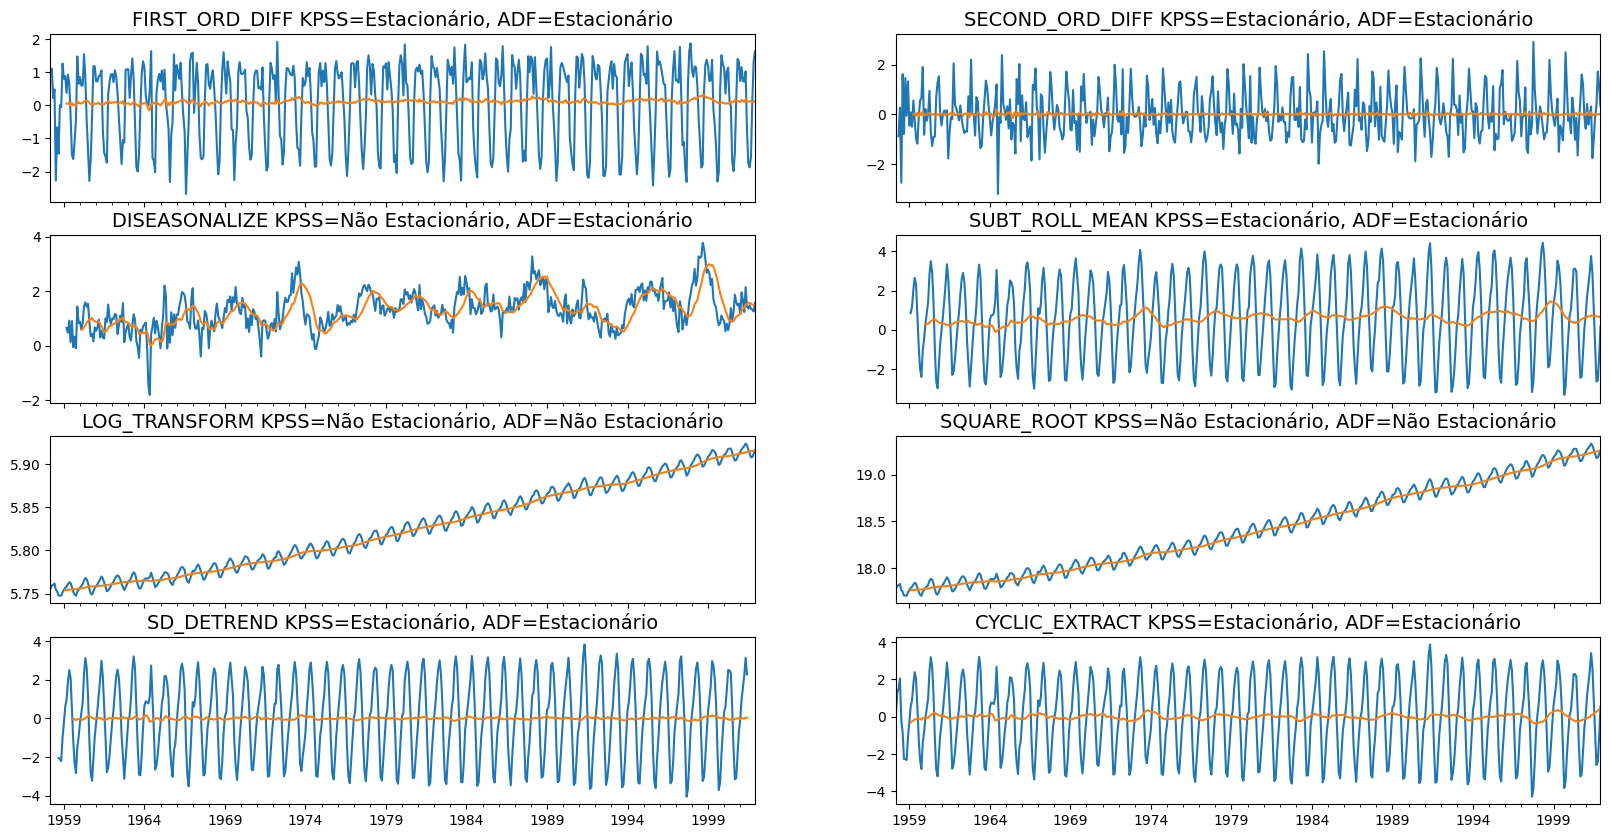

In [20]:
serie = co2_s

# using first order differencing (detrending)
first_ord_diff = serie.diff().dropna()

# using second order differencing
second_ord_diff = serie.diff().diff().dropna()

# differencing to remove seasonality
diseasonalize = serie.diff(12).dropna()

# using rolling mean 
rolling_mean = serie.rolling(window=12).mean()
subt_roll_mean = serie - rolling_mean

# log transform
log_transform = np.log(serie)

# Square root transform
square_root = np.sqrt(serie)

# using seasonal_decompose to remove trend
decomp = seasonal_decompose(serie)
sd_detrend = (decomp.observed - decomp.trend)

# using hp_filter 
cyclic_extract, trend = hpfilter(serie)

# combine the methods into a list
methods = [first_ord_diff, second_ord_diff, 
           diseasonalize, subt_roll_mean, 
           log_transform, square_root,
           sd_detrend, cyclic_extract]

warnings.simplefilter(action='ignore')
plot = plot_comparison(methods)

Quando você decide tirar a tendência dos dados você está removendo um elemento de distração, para você poder focar em padrões escondidos nos dados.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro, boxcox
from statsmodels.stats.api import (het_breuschpagan, 
                                   het_goldfeldquandt, 
                                   het_white, jarque_bera,
                                   omni_normtest, normal_ad)
from statsmodels.stats.diagnostic import kstest_normal, normal_ad
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.formula.api import ols
from statsmodels.tools.tools import add_constant

In [ ]:
from scipy.stats import shapiro, kstest, normaltest
from statsmodels.stats.diagnostic import kstest_normal, normal_ad

In [ ]:
def is_normal(test, p_level=0.05):
    stat, pval = test
    return 'Normal' if pval > 0.05 else 'Not Normal'

In [ ]:
normal_args = (np.mean(co2_df),np.std(co2_df))

print(is_normal(shapiro(co2_df)))
print(is_normal(normaltest(co2_df)))
print(is_normal(normal_ad(co2_df)))
print(is_normal(kstest_normal(co2_df)))
print(is_normal(kstest(co2_df, 
                   cdf='norm', 
                   args=normal_args)))

In [ ]:
co2_df.diff().hist()

In [ ]:
from statsmodels.tsa.ar_model import AutoReg

model = AutoReg(co2_df.dropna(), lags=1, trend='n').fit()

In [ ]:
print(is_normal(shapiro(model.resid)))
print(is_normal(normaltest(model.resid)))
print(is_normal(normal_ad(model.resid)))
print(is_normal(kstest_normal(model.resid)))
print(is_normal(kstest(model.resid, 
                   cdf='norm', 
                   args=(np.mean(model.resid), np.std(model.resid)))))

In [ ]:
plt.hist(model.resid)

In [ ]:

model.resid.mean()

In [ ]:
from statsmodels.graphics.gofplots import qqplot
qqplot(model.resid, line='q');

In [ ]:
plot_acf(model.resid);plt.show()

In [ ]:
model.plot_diagnostics();plt.show()

In [ ]:
model.test_normality()

In [ ]:
model.test_heteroskedasticity()

In [ ]:
from statsmodels.stats.api import (het_breuschpagan, 
                                   het_white)

In [ ]:
def het_test(model, test=het_breuschpagan):
    lm, lm_pvalue, fvalue, f_pvalue = (
        het_breuschpagan(model.resid, 
                         add_constant(
                             model.fittedvalues)
                        ))
    
    return "Heteroskedastic" if f_pvalue < 0.05 else "Homoskedastic"

In [ ]:
het_test(model, test=het_breuschpagan)

In [ ]:
het_test(model, test=het_white)

In [ ]:
from scipy.stats import boxcox

In [ ]:
xt, lmbda = boxcox(airp_df['value'])

In [ ]:
xts = pd.Series(xt, index=airp_df.index)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16,5))
airp_df.hist(ax=ax[0])
ax[0].set_title('Original Time Series')
xts.hist(ax=ax[1])
ax[1].set_title('Box-Cox Transformed')
plt.savefig('images/fig_9.23.png', bbox_inches='tight')

In [ ]:

fig, ax = plt.subplots(1, 2, figsize=(16,5))
airp_df.plot(ax=ax[0])
ax[0].set_title('Original Time Series')
xts.plot(ax=ax[1])
ax[1].set_title('Box-Cox Transformed')
#plt.savefig('images/fig_9.24.png', bbox_inches='tight')

In [ ]:
model_airp = AutoReg(airp_df, lags=1, trend='n').fit()
model_bx = AutoReg(xts, lags=1, trend='n').fit()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16,5))
model_airp.resid.plot(ax=ax[0])
ax[0].set_title('Residuals Plot - Regular Time Series')
model_bx.resid.plot(ax=ax[1])
ax[1].set_title('Residual Plot - Box-Cox Transformed')
#plt.savefig('images/fig_9.25.png', bbox_inches='tight')